> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

We will be accessing files on S3 in this notebook. Since those files are public, we set the `AWS_NO_SIGN_REQUEST` to tell `rasterio` to skip the sign-in.

In [ ]:
%env AWS_NO_SIGN_REQUEST=YES

# Using Raster Vision with Lightning

![The Lightning logo.](../../img/lightning-logo.png "The Lightning logo.")

[Lightning](https://www.pytorchlightning.ai/) (formerly known as PyTorch Lightning) is a high-level library for training PyTorch models. In this tutorial, we demonstrate a complete workflow for doing semantic segmentation on SpaceNet Vegas using a combination of Raster Vision and Lightning. We use Raster Vision for reading data, Lightning for training a model, and then Raster Vision again for making predictions and evaluations on whole scenes. 

Raster Vision has easy-to-use, built-in model training functionality implemented by the `Learner` class which is shown in the ["Training a model" tutorial](./train.ipynb). However, some users may prefer to use Lightning for training models, either because they already know how to use it, and like it, or because they desire more flexibility than the `Learner` class offers. This notebook shows how these libraries can be used together, but does not attempt to use either library in a particularly sophisticated manner.

First, we need to install `pytorch-lightning` since it is not a dependency of Raster Vision.

In [ ]:
%pip install pytorch-lightning==2.*

## Define training and validation datasets

We use Raster Vision to create training and validation `Dataset` objects. To keep things simple, we use a single scene for training and the same for validation. In a real workflow we would use many more scenes.

In [3]:
import albumentations as A

from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset,
    SemanticSegmentationVisualizer)
from rastervision.core.data import ClassConfig, StatsTransformer

In [4]:
scene_id = 5631
train_image_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img{scene_id}.tif'
train_label_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img{scene_id}.geojson'

class_config = ClassConfig(
    names=['building', 'background'], 
    colors=['orange', 'black'],
    null_class='background')

data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.RGBShift()
])

train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=train_image_uri,
    label_vector_uri=train_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size_lims=(200, 250),
    out_size=325,
    max_windows=10,
    transform=data_augmentation_transform,
    padding=50,
    image_raster_source_kw=dict(raster_transformers=[
        StatsTransformer(means=[562.7, 716.6, 517.1], stds=[341.1, 341.5, 197.5])
    ])
)

2024-04-10 15:02:46:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img5631.tif.
2024-04-10 15:02:46:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img5631.geojson.


To check that data is being read correctly, we use the `Visualizer` to plot a batch.

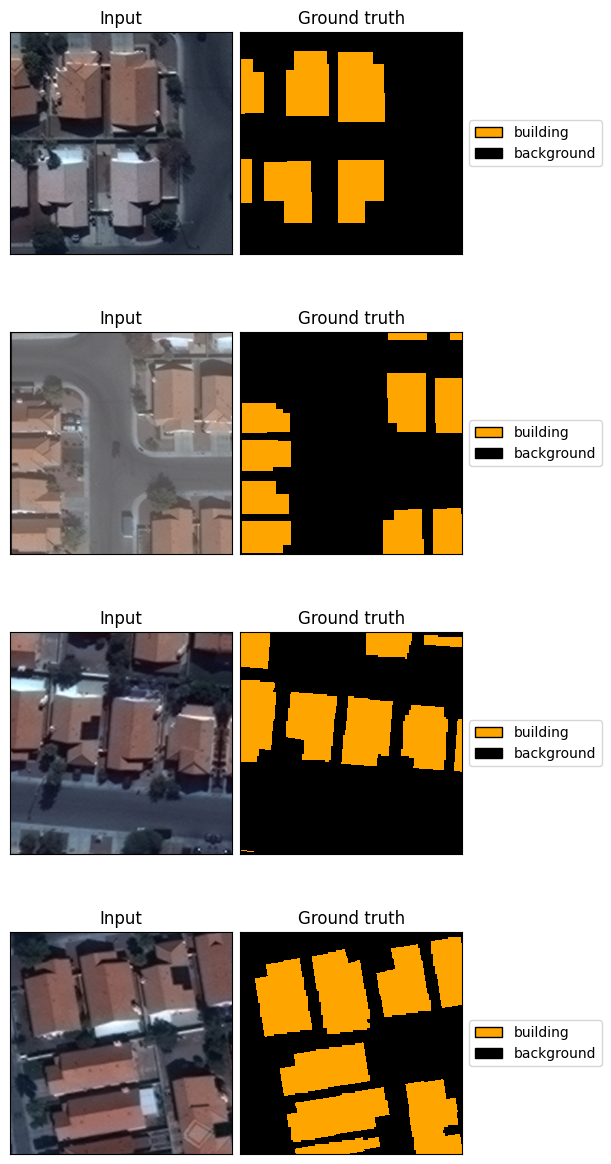

In [5]:
viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)
x, y = viz.get_batch(train_ds, 4)
viz.plot_batch(x, y, show=True)

In [6]:
scene_id = 5632
val_image_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img{scene_id}.tif'
val_label_uri = f's3://spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img{scene_id}.geojson'

val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=val_image_uri,
    label_vector_uri=val_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size=325,
    stride=100,
    out_size=325,
)

2024-04-10 15:02:46:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img5632.tif.
2024-04-10 15:02:46:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/geojson_buildings/SN2_buildings_train_AOI_2_Vegas_geojson_buildings_img5632.geojson.


## Train Model using Lightning

Here we build a DeepLab-ResNet50 model, and then train it using Lightning. We only train for 3 epochs so this can run in a minute or so on a CPU. In a real workflow we would train for 10-100 epochs on GPU. Because of this, the model will not be accurate at all.

In [7]:
from tqdm.autonotebook import tqdm
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision.models.segmentation import deeplabv3_resnet50
import pytorch_lightning as pl

from rastervision.pipeline.file_system import make_dir

In [8]:
batch_size = 8
lr = 1e-4
epochs = 3
output_dir = './lightning-demo/'
make_dir(output_dir)
fast_dev_run = False

In [9]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=4)

One of the main abstractions in Lightning is the `LightningModule` which extends a PyTorch `nn.Module` with extra methods that define how to train and validate the model. Here we define a `LightningModule` that does the bare minimum to train a DeepLab semantic segmentation model.

In [10]:
class SemanticSegmentation(pl.LightningModule):
    def __init__(self, deeplab, lr=1e-4):
        super().__init__()
        self.deeplab = deeplab
        self.lr = lr

    def forward(self, img):
        return self.deeplab(img)['out']

    def training_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self.forward(img)
        loss = F.cross_entropy(out, mask)
        log_dict = {'train_loss': loss}
        self.log_dict(log_dict, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self.forward(img)
        loss = F.cross_entropy(out, mask)
        log_dict = {'validation_loss': loss}
        self.log_dict(log_dict, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr)
        return optimizer

The other main abstraction in Lighting is the `Trainer` which is responsible for actually training a `LightningModule`. This is configured to log metrics to Tensorboard.

In [11]:
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

deeplab = deeplabv3_resnet50(num_classes=len(class_config) + 1)
model = SemanticSegmentation(deeplab, lr=lr)
tb_logger = TensorBoardLogger(save_dir=output_dir, flush_secs=10)
trainer = pl.Trainer(
    accelerator='auto',
    min_epochs=1,
    max_epochs=epochs+1,
    default_root_dir=output_dir,
    logger=[tb_logger],
    fast_dev_run=fast_dev_run,
    log_every_n_steps=1,
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 42.4MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Monitor training using Tensorboard

This runs an instance of Tensorboard inside this notebook.

In [ ]:
%reload_ext tensorboard
%tensorboard --bind_all --logdir "./lightning-demo/lightning_logs" --reload_interval 10

![A screenshot of the Tensorboard dashboard.](../../img/tensorboard-lightning.png "A screenshot of the Tensorboard dashboard.")

In [12]:
trainer.fit(model, train_dl, val_dl)

You are using a CUDA device ('NVIDIA GeForce RTX 4080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: ./lightning-demo/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | deeplab | DeepLabV3 | 39.6 M
--------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.537   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=4` reached.


## Load saved model

After training the model for only 3 epochs, it will not make good predictions. In order to have some sensible looking output, we will loads weights from a model that was fully trained on SpaceNet Vegas.

In [21]:
weights_uri = 'https://s3.amazonaws.com/azavea-research-public-data/raster-vision/examples/model-zoo-0.30/spacenet-vegas-buildings-ss/model.pth'
state_dict = torch.hub.load_state_dict_from_url(weights_uri, map_location='cpu')
model.deeplab.load_state_dict(state_dict)

<All keys matched successfully>

### Load normalization stats

The model expects images to be normalized, so we load the stats needed to do that:

In [22]:
from rastervision.core.data import StatsTransformer

stats_uri = 's3://azavea-research-public-data/raster-vision/examples/model-zoo-0.30/spacenet-vegas-buildings-ss/analyze/stats/train_scenes/stats.json'
stats_tf = StatsTransformer.from_stats_json(stats_uri)
stats_tf

StatsTransformer(means=array([424.77525978, 593.13316996, 447.48274874]), stds=array([221.28096132, 244.1374012 , 149.42471905]), max_stds=3.0)

Next, we re-initialize `val_ds` and `val_dl` to make use of the stats. Note that we skip passing the `class_config` and label URI, since we will not be using this for training.

In [134]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    image_uri=val_image_uri,
    image_raster_source_kw=dict(raster_transformers=[stats_tf]),
    size=325,
    stride=325,
    out_size=325,
)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=4)

2024-04-10 16:05:27:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN2_buildings/train/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img5632.tif.


## Make predictions for scene

In [135]:
def get_predictions(dataloader):
    for x, _ in tqdm(dataloader):
        with torch.inference_mode():
            out_batch = model(x)
            out_batch = out_batch.softmax(dim=1)
        # This needs to yield a single prediction, not a whole batch of them.
        for out in out_batch:
            yield out.numpy()

In [136]:
from rastervision.core.data import SemanticSegmentationLabels

model.eval()
predictions = get_predictions(val_dl)
pred_labels = SemanticSegmentationLabels.from_predictions(
    val_ds.windows,
    predictions,
    smooth=True,
    extent=val_ds.scene.extent,
    num_classes=len(class_config),
)
scores = pred_labels.get_score_arr(pred_labels.extent)

  0%|          | 0/1 [00:00<?, ?it/s]

## Visualize and then save predictions

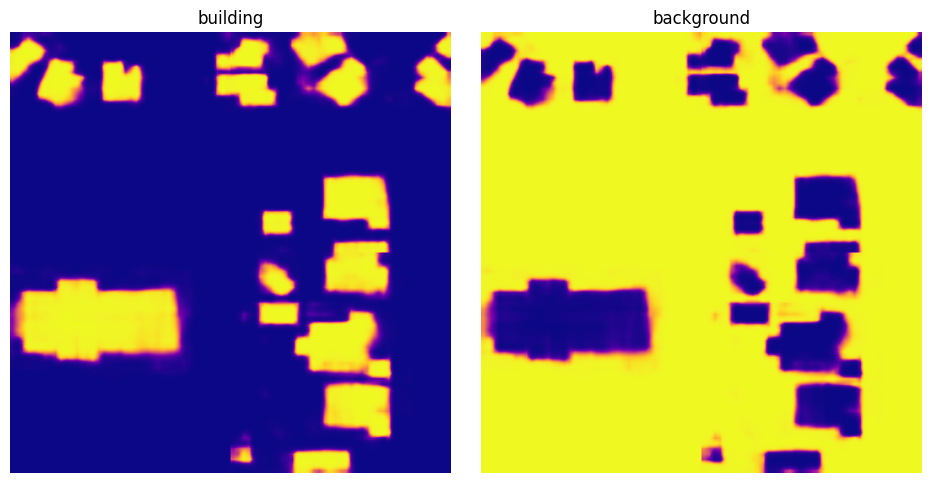

In [137]:
from matplotlib import pyplot as plt

scores_building = scores[0]
scores_background = scores[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(w_pad=-2)
ax1.imshow(scores_building, cmap='plasma')
ax1.axis('off')
ax1.set_title('building')
ax2.imshow(scores_background, cmap='plasma')
ax2.axis('off')
ax2.set_title('background')
plt.show()

In [141]:
from os.path import join

pred_labels.save(
    uri=join(output_dir, 'predictions'),
    crs_transformer=val_ds.scene.raster_source.crs_transformer,
    class_config=class_config)

Saving pixel labels:   0%|          | 0/2 [00:00<?, ?it/s]

Saving pixel scores:   0%|          | 0/2 [00:00<?, ?it/s]

## What next?

See the [Evaluate predictions tutorial](pred_and_eval_ss.ipynb#Evaluate-predictions) to see how to compute performance metrics for these predictions.